## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q efficientnet-pytorch albumentations grad-cam scikit-plot
!pip install -q timm torch torchvision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Clone Dataset from GitHub

In [3]:
# Clone the repository
!git clone https://github.com/Tvenkatathanuj/SDP.git

# Set paths
DATA_PATH = '/content/SDP/handwritten dataset/Dataset/Dataset'
HEALTHY_PATH = os.path.join(DATA_PATH, 'Healthy')
PARKINSON_PATH = os.path.join(DATA_PATH, 'Parkinson')

print(f"Healthy samples: {len(os.listdir(HEALTHY_PATH))}")
print(f"Parkinson samples: {len(os.listdir(PARKINSON_PATH))}")

Cloning into 'SDP'...
remote: Enumerating objects: 3379, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3379 (delta 11), reused 15 (delta 7), pack-reused 3360 (from 1)
Receiving objects: 100% (3379/3379), 255.94 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (3352/3352), done.
Healthy samples: 1632
Parkinson samples: 1632


## 3. Data Exploration and Visualization

In [4]:
# Prepare dataset dataframe
data = []

for img_name in os.listdir(HEALTHY_PATH):
    data.append({
        'image_path': os.path.join(HEALTHY_PATH, img_name),
        'label': 0,  # Healthy
        'class_name': 'Healthy'
    })

for img_name in os.listdir(PARKINSON_PATH):
    data.append({
        'image_path': os.path.join(PARKINSON_PATH, img_name),
        'label': 1,  # Parkinson
        'class_name': 'Parkinson'
    })

df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")
print(f"\nClass distribution:\n{df['class_name'].value_counts()}")
df.head()

Total samples: 3264

Class distribution:
class_name
Healthy      1632
Parkinson    1632
Name: count, dtype: int64


,image_path,label,class_name
0,/content/SDP/handwritten dataset/Dataset/Datas...,0,Healthy
1,/content/SDP/handwritten dataset/Dataset/Datas...,0,Healthy
2,/content/SDP/handwritten dataset/Dataset/Datas...,0,Healthy
3,/content/SDP/handwritten dataset/Dataset/Datas...,0,Healthy
4,/content/SDP/handwritten dataset/Dataset/Datas...,0,Healthy


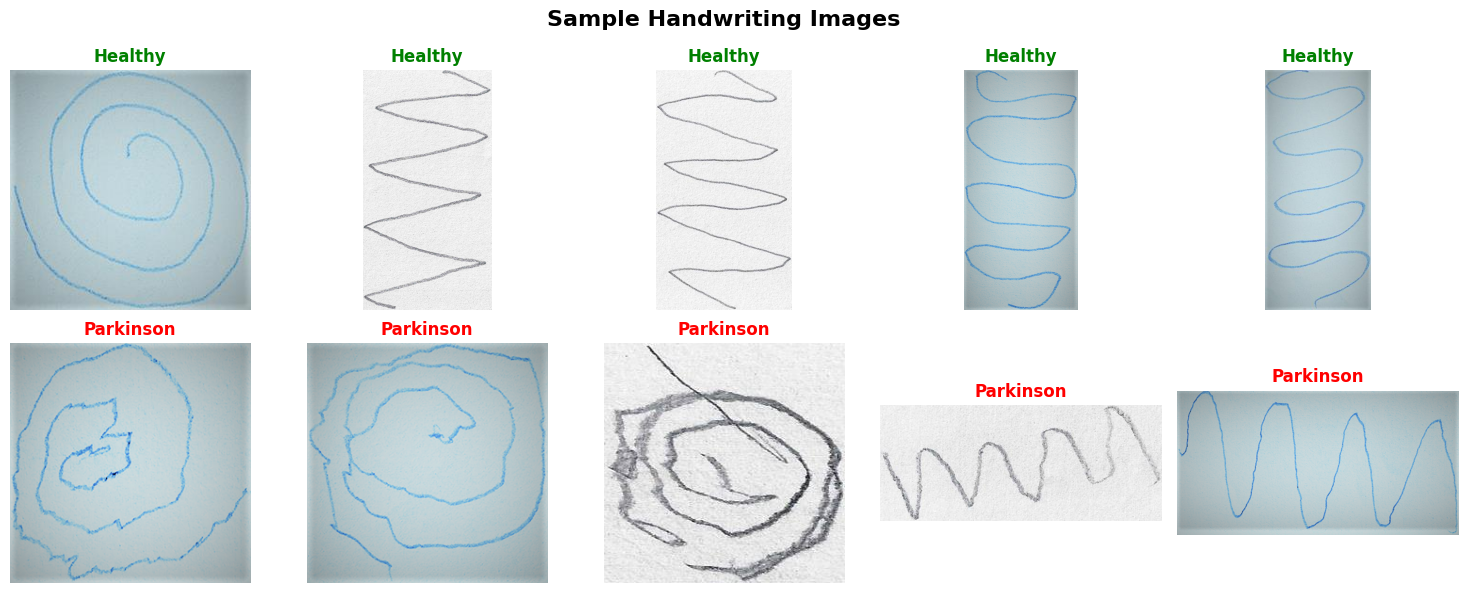

In [5]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Handwriting Images', fontsize=16, fontweight='bold')

# Healthy samples
healthy_samples = df[df['label'] == 0].sample(5)
for i, (idx, row) in enumerate(healthy_samples.iterrows()):
    img = Image.open(row['image_path'])
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('Healthy', color='green', fontweight='bold')
    axes[0, i].axis('off')

# Parkinson samples
parkinson_samples = df[df['label'] == 1].sample(5)
for i, (idx, row) in enumerate(parkinson_samples.iterrows()):
    img = Image.open(row['image_path'])
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('Parkinson', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 4. Custom Dataset with Advanced Augmentation

In [6]:
class HandwritingDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_augmentation=False):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.use_augmentation = use_augmentation

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.long)

# Define augmentations
train_transform = A.Compose([
    A.Resize(380, 380),
    A.RandomCrop(336, 336),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MotionBlur(blur_limit=5),
    ], p=0.3),
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50),
    ], p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(336, 336),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

print("Augmentation pipelines created!")

Augmentation pipelines created!


## 5. Novel Model Architecture: EfficientNet-B4 + SPP + CBAM

In [7]:
class ChannelAttention(nn.Module):
    """CBAM Channel Attention Module"""
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """CBAM Spatial Attention Module"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class SpatialPyramidPooling(nn.Module):
    """Spatial Pyramid Pooling for multi-scale features"""
    def __init__(self, pool_sizes=[1, 2, 4]):
        super(SpatialPyramidPooling, self).__init__()
        self.pool_sizes = pool_sizes

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        pools = []

        for pool_size in self.pool_sizes:
            pool = F.adaptive_avg_pool2d(x, (pool_size, pool_size))
            pool = pool.view(batch_size, -1)  # Flatten to (batch, channels * pool_size^2)
            pools.append(pool)

        out = torch.cat(pools, dim=1)  # Concatenate along feature dimension
        return out

class HandwritingParkinsonsModel(nn.Module):
    """Novel Architecture: EfficientNet-B4 + SPP + CBAM + Multi-Head Classifier"""
    def __init__(self, num_classes=2, pretrained=True):
        super(HandwritingParkinsonsModel, self).__init__()

        # EfficientNet-B4 backbone
        self.backbone = timm.create_model('efficientnet_b4', pretrained=pretrained, features_only=True)

        # Get actual output channels from the last feature map
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features[-1].shape[1]  # Get channels from last feature map

        # CBAM attention
        self.cbam = CBAM(feature_dim)

        # Spatial Pyramid Pooling
        self.spp = SpatialPyramidPooling(pool_sizes=[1, 2, 4])
        spp_out_dim = feature_dim * (1*1 + 2*2 + 4*4)  # feature_dim * 21

        # Classification head with stronger regularization
        self.classifier = nn.Sequential(
            nn.Linear(spp_out_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

        # Feature extractor for fusion model
        self.feature_extractor = nn.Sequential(
            nn.Linear(spp_out_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, return_features=False):
        # Extract features from backbone
        features = self.backbone(x)
        x = features[-1]  # Get last feature map

        # Apply CBAM attention
        x = self.cbam(x)

        # Spatial Pyramid Pooling
        x = self.spp(x)
        x = x.view(x.size(0), -1)

        if return_features:
            # Return features for fusion
            features = self.feature_extractor(x)
            return features

        # Classification
        out = self.classifier(x)
        return out

print("Model architecture defined!")

Model architecture defined!


## 6. Focal Loss for Imbalanced Learning

In [8]:
class FocalLoss(nn.Module):
    """Focal Loss for handling hard examples"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("Focal Loss defined!")

Focal Loss defined!


## 7. Training Functions

In [9]:
def mixup_data(x, y, alpha=0.2):
    """Mixup data augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss criterion"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None, use_mixup=False):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Apply Mixup
        if use_mixup:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)

        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                if use_mixup:
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        if use_mixup:
            all_labels.extend(labels_a.cpu().numpy())  # Use original labels for accuracy
        else:
            all_labels.extend(labels.cpu().numpy())

        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds) if all_labels else 0

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_labels, all_preds, all_probs

print("Training functions ready!")

Training functions ready!


## 8. Data Preparation and Training

In [10]:
# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Create datasets
train_dataset = HandwritingDataset(train_df, transform=train_transform, use_augmentation=True)
val_dataset = HandwritingDataset(val_df, transform=val_transform, use_augmentation=False)
test_dataset = HandwritingDataset(test_df, transform=val_transform, use_augmentation=False)

# Create dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created!")

Train: 2284, Val: 490, Test: 490
DataLoaders created!


In [11]:
# Initialize model
model = HandwritingParkinsonsModel(num_classes=2, pretrained=True).to(device)

# Loss and optimizer with stronger regularization
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-4)  # Lower LR, higher weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Early stopping
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Mixed precision training
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Ready to train!")


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model parameters: 26,536,620
Ready to train!


In [12]:
# Training loop with Mixup augmentation enabled
NUM_EPOCHS = 50
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Train with Mixup augmentation
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler, use_mixup=True)

    # Validate
    val_loss, val_acc, _, _, _ = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model based on validation loss (not accuracy to prevent overfitting)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_handwriting_model.pth')
        print(f"✓ Model saved with val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\nBest Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.47it/s, loss=0.026]


Train Loss: 0.0543, Train Acc: 0.5595
Val Loss: 0.0260, Val Acc: 0.8449
✓ Model saved with val_acc: 0.8449, val_loss: 0.0260

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.37it/s, loss=0.0258]


Train Loss: 0.0491, Train Acc: 0.5946
Val Loss: 0.0258, Val Acc: 0.8510
✓ Model saved with val_acc: 0.8510, val_loss: 0.0258

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.69it/s, loss=0.022]


Train Loss: 0.0474, Train Acc: 0.6042
Val Loss: 0.0220, Val Acc: 0.8816
✓ Model saved with val_acc: 0.8816, val_loss: 0.0220

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.38it/s, loss=0.0217]


Train Loss: 0.0434, Train Acc: 0.6322
Val Loss: 0.0217, Val Acc: 0.8857
✓ Model saved with val_acc: 0.8857, val_loss: 0.0217

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.71it/s, loss=0.0196]


Train Loss: 0.0415, Train Acc: 0.6243
Val Loss: 0.0196, Val Acc: 0.9020
✓ Model saved with val_acc: 0.9020, val_loss: 0.0196

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.43it/s, loss=0.0193]


Train Loss: 0.0415, Train Acc: 0.6475
Val Loss: 0.0193, Val Acc: 0.8980
✓ Model saved with val_acc: 0.8980, val_loss: 0.0193

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.67it/s, loss=0.0193]


Train Loss: 0.0413, Train Acc: 0.6116
Val Loss: 0.0193, Val Acc: 0.9041
✓ Model saved with val_acc: 0.9041, val_loss: 0.0193

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.43it/s, loss=0.0186]


Train Loss: 0.0416, Train Acc: 0.6195
Val Loss: 0.0186, Val Acc: 0.8980
✓ Model saved with val_acc: 0.8980, val_loss: 0.0186

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.74it/s, loss=0.0189]


Train Loss: 0.0411, Train Acc: 0.6169
Val Loss: 0.0189, Val Acc: 0.8816
No improvement. Patience: 1/10

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.31it/s, loss=0.0189]


Train Loss: 0.0380, Train Acc: 0.6484
Val Loss: 0.0189, Val Acc: 0.8918
No improvement. Patience: 2/10

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.72it/s, loss=0.0187]


Train Loss: 0.0377, Train Acc: 0.6331
Val Loss: 0.0187, Val Acc: 0.8878
No improvement. Patience: 3/10

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.47it/s, loss=0.0183]


Train Loss: 0.0390, Train Acc: 0.6252
Val Loss: 0.0183, Val Acc: 0.8980
✓ Model saved with val_acc: 0.8980, val_loss: 0.0183

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.71it/s, loss=0.0173]


Train Loss: 0.0349, Train Acc: 0.6239
Val Loss: 0.0173, Val Acc: 0.9041
✓ Model saved with val_acc: 0.9041, val_loss: 0.0173

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.42it/s, loss=0.0156]


Train Loss: 0.0339, Train Acc: 0.6532
Val Loss: 0.0156, Val Acc: 0.9143
✓ Model saved with val_acc: 0.9143, val_loss: 0.0156

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.73it/s, loss=0.0153]


Train Loss: 0.0336, Train Acc: 0.6725
Val Loss: 0.0153, Val Acc: 0.9204
✓ Model saved with val_acc: 0.9204, val_loss: 0.0153

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.03it/s, loss=0.0149]


Train Loss: 0.0335, Train Acc: 0.6751
Val Loss: 0.0149, Val Acc: 0.9163
✓ Model saved with val_acc: 0.9163, val_loss: 0.0149

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.71it/s, loss=0.0139]


Train Loss: 0.0328, Train Acc: 0.6292
Val Loss: 0.0139, Val Acc: 0.9327
✓ Model saved with val_acc: 0.9327, val_loss: 0.0139

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.07it/s, loss=0.0143]


Train Loss: 0.0316, Train Acc: 0.6405
Val Loss: 0.0143, Val Acc: 0.9204
No improvement. Patience: 1/10

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.72it/s, loss=0.0142]


Train Loss: 0.0297, Train Acc: 0.6708
Val Loss: 0.0142, Val Acc: 0.9224
No improvement. Patience: 2/10

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.00it/s, loss=0.0133]


Train Loss: 0.0305, Train Acc: 0.6821
Val Loss: 0.0133, Val Acc: 0.9347
✓ Model saved with val_acc: 0.9347, val_loss: 0.0133

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.72it/s, loss=0.0133]


Train Loss: 0.0300, Train Acc: 0.6865
Val Loss: 0.0133, Val Acc: 0.9429
No improvement. Patience: 1/10

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.24it/s, loss=0.0126]


Train Loss: 0.0305, Train Acc: 0.6664
Val Loss: 0.0126, Val Acc: 0.9367
✓ Model saved with val_acc: 0.9367, val_loss: 0.0126

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.58it/s, loss=0.0127]


Train Loss: 0.0308, Train Acc: 0.6677
Val Loss: 0.0127, Val Acc: 0.9408
No improvement. Patience: 1/10

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.66it/s, loss=0.0126]


Train Loss: 0.0290, Train Acc: 0.6782
Val Loss: 0.0126, Val Acc: 0.9347
✓ Model saved with val_acc: 0.9347, val_loss: 0.0126

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.41it/s, loss=0.0119]


Train Loss: 0.0312, Train Acc: 0.6524
Val Loss: 0.0119, Val Acc: 0.9408
✓ Model saved with val_acc: 0.9408, val_loss: 0.0119

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.70it/s, loss=0.0125]


Train Loss: 0.0293, Train Acc: 0.6966
Val Loss: 0.0125, Val Acc: 0.9429
No improvement. Patience: 1/10

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.37it/s, loss=0.012]


Train Loss: 0.0303, Train Acc: 0.7018
Val Loss: 0.0120, Val Acc: 0.9429
No improvement. Patience: 2/10

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.74it/s, loss=0.012]


Train Loss: 0.0280, Train Acc: 0.6804
Val Loss: 0.0120, Val Acc: 0.9429
No improvement. Patience: 3/10

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.37it/s, loss=0.012]


Train Loss: 0.0293, Train Acc: 0.7032
Val Loss: 0.0120, Val Acc: 0.9408
No improvement. Patience: 4/10

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.69it/s, loss=0.0122]


Train Loss: 0.0283, Train Acc: 0.6664
Val Loss: 0.0122, Val Acc: 0.9408
No improvement. Patience: 5/10

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.19it/s, loss=0.0119]


Train Loss: 0.0297, Train Acc: 0.6795
Val Loss: 0.0119, Val Acc: 0.9469
No improvement. Patience: 6/10

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.66it/s, loss=0.0111]


Train Loss: 0.0275, Train Acc: 0.6817
Val Loss: 0.0111, Val Acc: 0.9510
✓ Model saved with val_acc: 0.9510, val_loss: 0.0111

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.31it/s, loss=0.0116]


Train Loss: 0.0285, Train Acc: 0.6686
Val Loss: 0.0116, Val Acc: 0.9429
No improvement. Patience: 1/10

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:03<00:00,  7.77it/s, loss=0.0109]


Train Loss: 0.0250, Train Acc: 0.6905
Val Loss: 0.0109, Val Acc: 0.9469
✓ Model saved with val_acc: 0.9469, val_loss: 0.0109

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.28it/s, loss=0.0102]


Train Loss: 0.0291, Train Acc: 0.6848
Val Loss: 0.0102, Val Acc: 0.9531
✓ Model saved with val_acc: 0.9531, val_loss: 0.0102

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:03<00:00,  7.76it/s, loss=0.00957]


Train Loss: 0.0251, Train Acc: 0.6909
Val Loss: 0.0096, Val Acc: 0.9592
✓ Model saved with val_acc: 0.9592, val_loss: 0.0096

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.61it/s, loss=0.00977]


Train Loss: 0.0249, Train Acc: 0.6874
Val Loss: 0.0098, Val Acc: 0.9531
No improvement. Patience: 1/10

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:03<00:00,  7.76it/s, loss=0.00891]


Train Loss: 0.0256, Train Acc: 0.6935
Val Loss: 0.0089, Val Acc: 0.9612
✓ Model saved with val_acc: 0.9612, val_loss: 0.0089

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.72it/s, loss=0.00787]


Train Loss: 0.0251, Train Acc: 0.6953
Val Loss: 0.0079, Val Acc: 0.9735
✓ Model saved with val_acc: 0.9735, val_loss: 0.0079

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.24it/s, loss=0.00814]


Train Loss: 0.0246, Train Acc: 0.6830
Val Loss: 0.0081, Val Acc: 0.9714
No improvement. Patience: 1/10

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.69it/s, loss=0.00857]


Train Loss: 0.0250, Train Acc: 0.7123
Val Loss: 0.0086, Val Acc: 0.9571
No improvement. Patience: 2/10

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.35it/s, loss=0.00877]


Train Loss: 0.0241, Train Acc: 0.7062
Val Loss: 0.0088, Val Acc: 0.9653
No improvement. Patience: 3/10

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.72it/s, loss=0.00751]


Train Loss: 0.0245, Train Acc: 0.6786
Val Loss: 0.0075, Val Acc: 0.9816
✓ Model saved with val_acc: 0.9816, val_loss: 0.0075

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.00it/s, loss=0.00796]


Train Loss: 0.0235, Train Acc: 0.7137
Val Loss: 0.0080, Val Acc: 0.9735
No improvement. Patience: 1/10

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.68it/s, loss=0.00798]


Train Loss: 0.0237, Train Acc: 0.7036
Val Loss: 0.0080, Val Acc: 0.9735
No improvement. Patience: 2/10

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.10it/s, loss=0.00728]


Train Loss: 0.0217, Train Acc: 0.7482
Val Loss: 0.0073, Val Acc: 0.9776
✓ Model saved with val_acc: 0.9776, val_loss: 0.0073

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.71it/s, loss=0.00747]


Train Loss: 0.0228, Train Acc: 0.6909
Val Loss: 0.0075, Val Acc: 0.9776
No improvement. Patience: 1/10

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.33it/s, loss=0.00669]


Train Loss: 0.0219, Train Acc: 0.7053
Val Loss: 0.0067, Val Acc: 0.9755
✓ Model saved with val_acc: 0.9755, val_loss: 0.0067

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.63it/s, loss=0.00729]


Train Loss: 0.0240, Train Acc: 0.7119
Val Loss: 0.0073, Val Acc: 0.9816
No improvement. Patience: 1/10

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.48it/s, loss=0.007]

Train Loss: 0.0232, Train Acc: 0.7097
Val Loss: 0.0070, Val Acc: 0.9837
No improvement. Patience: 2/10

Best Validation Loss: 0.0067
Best Validation Accuracy: 0.9755


## 9. Evaluation and Metrics

In [13]:
# Load best model
checkpoint = torch.load('best_handwriting_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test evaluation
test_loss, test_acc, y_true, y_pred, y_probs = validate_epoch(model, test_loader, criterion, device)

print(f"\n{'='*50}")
print(f"TEST SET PERFORMANCE")
print(f"{'='*50}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parkinson'], digits=4))

# Additional metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Validation: 100%|██████████| 31/31 [00:04<00:00,  7.51it/s, loss=0.00617]


TEST SET PERFORMANCE
Test Accuracy: 0.9796
Test Loss: 0.0062

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.9835    0.9755    0.9795       245
   Parkinson     0.9757    0.9837    0.9797       245

    accuracy                         0.9796       490
   macro avg     0.9796    0.9796    0.9796       490
weighted avg     0.9796    0.9796    0.9796       490


Precision: 0.9757
Recall (Sensitivity): 0.9837
F1-Score: 0.9797
AUC-ROC: 0.9981


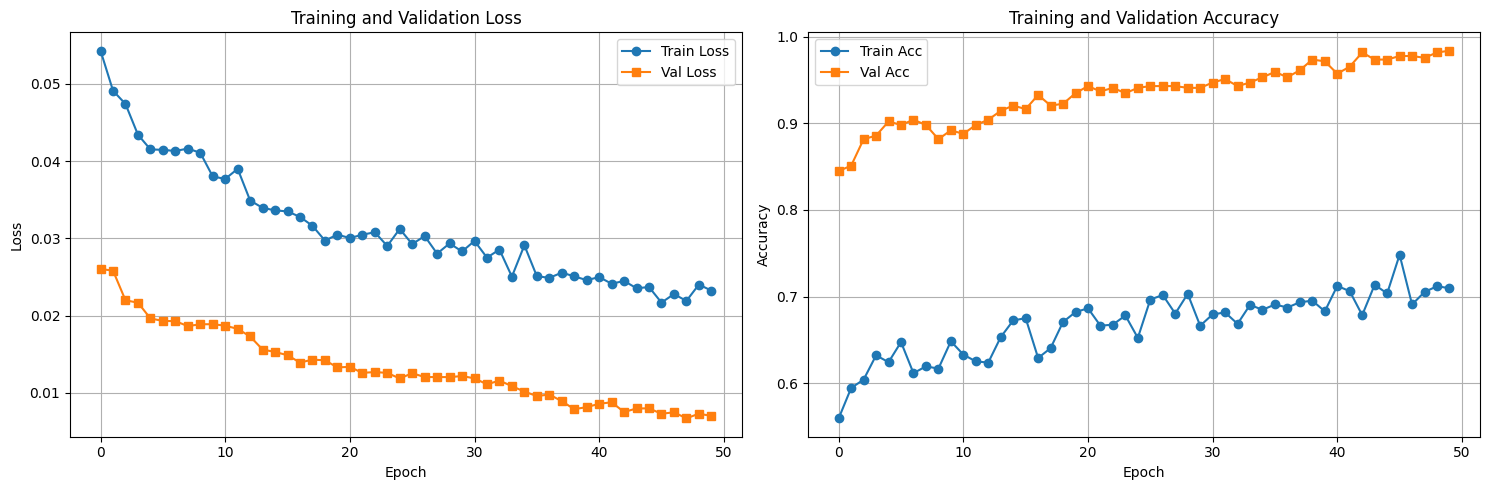

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('handwriting_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

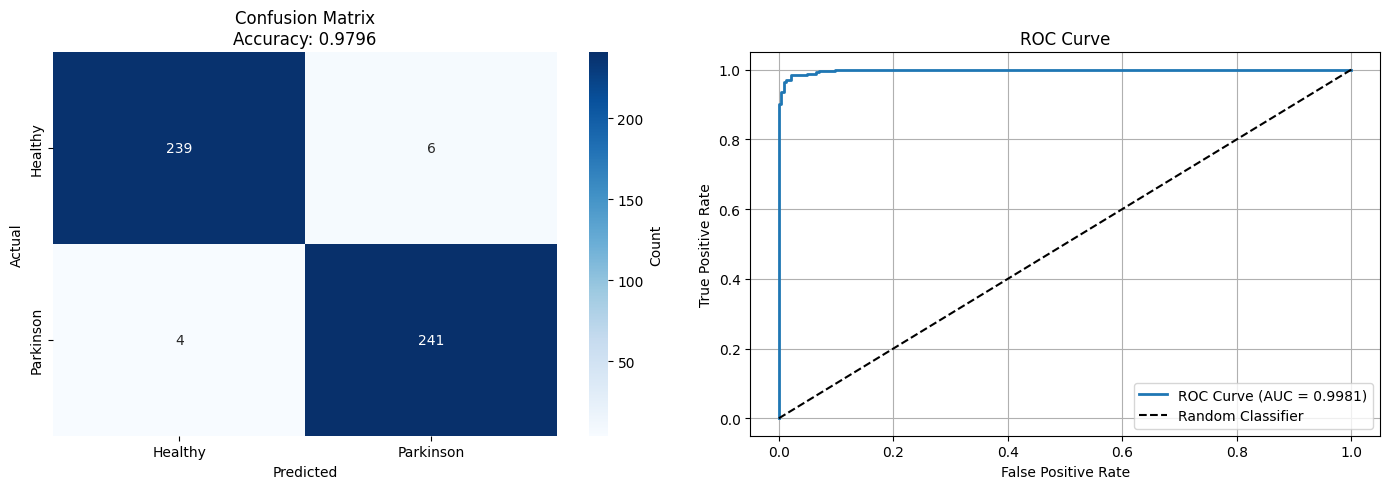

In [15]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'], ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix\nAccuracy: {test_acc:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('handwriting_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Save Model for Fusion

In [16]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_auc': auc,
}, 'handwriting_parkinsons_model_final.pth')

print("✓ Model saved for fusion: handwriting_parkinsons_model_final.pth")
print(f"\nFinal Performance:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC-ROC: {auc:.4f}")
print(f"  F1-Score: {f1:.4f}")

✓ Model saved for fusion: handwriting_parkinsons_model_final.pth

Final Performance:
  Accuracy: 0.9796
  AUC-ROC: 0.9981
  F1-Score: 0.9797
